## Deep troll (Gemidao do Whatsapp) detector



Cansado de ser pego nessas brincadeiras sem graça do Whatsapp? Já ficou em alguma saia justa? 

Vamos colocar o Deep Learning para trabalhar para o bem! O deeptroll usa um modelo de aprendizado profundo que identifica se um áudio contém o Gemidao (AAAWN OOOWN NHAAA AWWWWN AAAAAH).

O modelo usa uma arquitetura RNN-GRU, usando convoluções em espectrogramas de áudio para extrair as features.


In [23]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from spectrogram import *
from td_utils import *
%matplotlib inline
import sys,os,os.path


#from apiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools

# Data synthesis: Creating the speech dataset 

We start by building a dataset for the troll detection algorithm. We would like to detect the "troll" in Whatsapp audios. We thus need to create recordings with a mix of positive sounds ("AAAWN OOOWN NHAAA AWWWWN AAAAAH") and negative words (regular whatsapp audios).]

   Lets download the raw dataset. The `tar` public on my Google Drive at:
   
   `https://drive.google.com/file/d/1wBfrJ7UPC0BLJZlJRlSZgSHxC_YButiF/view?usp=sharing`
   
   Download it, decompress and place in the projects folder with name `data` (automating the download would be a nice contribution to start :)


In [24]:
# DOWNLOAD before running this cell -> 'https://drive.google.com/file/d/1wBfrJ7UPC0BLJZlJRlSZgSHxC_YButiF/view?usp=sharing'
#% tar -xzvf deeptroll-data.tar.gz


## Listening to the data   

In the downloaded raw_data directory, you can find a total of 454 whatsapp audio files. We use these audio files to synthesize a dataset to train the model. The "troll" directory contains positive examples of people screaming "AAAWN OOOWN NHAAA AWWWWN AAAAAH". The "regular" directory contains the regular examples of Whatsapp audio files.

The audio files range from 10 seconds to 5 minutes audio clips

Run the cells below to listen to some examples.

In [25]:
IPython.display.Audio("data/raw_data/audios/1.mp3")

In [26]:
IPython.display.Audio("data/raw_data/audios/2.mp3")


We will use two types of recordings (regular/troll) to create a labeled dataset.

# Data cleaning

As the inputs to the model are the spectrograms, we need to extract the dimensions of the audio files after parsing them to spectrograms. Once the raw data audio files have different sizes, they would generate different input sizes, which would not work for our model. For that reason, I've trimmed the audio files to 30 seconds clips.

To clean the audio files, I've used ffmpeg. First, we need to convert the raw_mp3 original files, to the wav format, which works better with our audio manipulation libs:

```
for i in *.mp3;
  do name=`echo $i | cut -d'.' -f1`;
  echo $name;
  ffmpeg -i "$i" -acodec pcm_u8 -ar 22050 "${name}.wav";
done
```

Then we trim the audio files to 30 seconds audio clips, in order to make the input size of our model fixed.

```
for i in *.wav;
  do name=`echo $i | cut -d'.' -f1`;
  echo $name;
  ffmpeg -t 30 -i "$i" 30-"$i";
done
```


Unfortunately, after converting and trimming, the 454 raw audio files dropped to 112 due to some kind of parsing problem. If you manage to increase this number, please, send your contribution so that we can get a better training set.

(101, 8267)


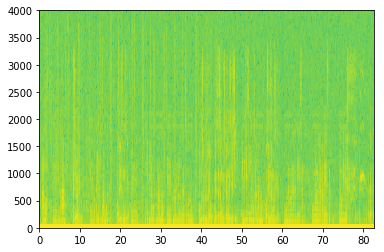

In [27]:
x = graph_spectrogram("./data/train/regular/4.wav")
print(x.shape)
Tx = 8267 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

We will encode our output in a $T_y = 2064$ vector representation, so:

In [28]:
Ty = 2064 # The number of time steps in the output of our model

## 1.3 - Generating a single training example

Because speech data is hard to acquire and label, we are synthesizing our training data using the audio clips of regular and trolls.

To synthesize a single training example, we will:

- Pick a random 30 seconds regular audio clip
- Randomly insert 0-4 audio clips of "trolls" into this 30sec clip

Because we had synthesized the "trolls" into the regular clips, we know exactly when in the 30sec clip the "troll" makes its appearance. We use that as our labels in the training set.

In [29]:
# vamos carregar os segmentos usando o pydub 
troll, regulars = load_raw_audio()


print("Regular len: " + str(len(regulars[3])))    # Deve ser aproximadamente 30,000, pois é um pedaço de 30 segundos, artificial.
print("Troll[0] len: " + str(len(troll[0])))     # Aproximadamente 5000, pois é o clip troll 

Regular len: 30000
Troll[0] len: 4990


**Overlaying trolls on the regular clips**:

Given a 30sec regular clip and a troll clip, we need to be able to "add" or "insert" the troll audio clip onto the regular. To ensure audio segments inserted onto the regular do not overlap, we will keep track of the times of previously inserted troll clips.

**Creating the labels at the same time we overlay**:

Given a regular clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any "troll." 

When we insert or overlay a "troll" clip, we will also update labels for $y^{\langle t \rangle}$, so that 50 steps of the output now have target label 1. We will train a GRU to detect when a troll has *finished* playing. 

To implement the training set synthesis process, we will use the following helper functions. All of these function will use a 1ms discretization interval, so the 30sec of audio is alwsys discretized into 30,000 steps. 

1. `get_random_time_segment(segment_ms)` gets a random time segment in our regular audio
2. `is_overlapping(segment_time, existing_segments)` checks if a time segment overlaps with existing segments
3. `insert_audio_clip(background, audio_clip, existing_times)` inserts an audio segment at a random time in our regular audio using `get_random_time_segment` and `is_overlapping`
4. `insert_ones(y, segment_end_ms)` inserts 1's into our label vector y after the word "activate"

In [30]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=30000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [31]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time

    overlap = False
    
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [78]:
def insert_audio_clip(regular, audio_clip, previous_segments):
    """
    Insert a new audio segment over the regular clip at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 30 second regular audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_regular -- the updated regular audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    segment_time = get_random_time_segment(segment_ms)
    
    while (is_overlapping(segment_time, previous_segments)):
        segment_time = get_random_time_segment(segment_ms)

    previous_segments.append(segment_time)
    
    # Vamos colocar o audio por cima. Vamos abaixar em 50 dB o som nesse momento 
    new_regular = regular.overlay(audio_clip, position = segment_time[0], gain_during_overlay=-50.0)
    
    return new_regular, segment_time

Segment Time:  (22606, 27595)


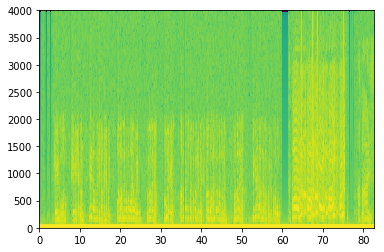

In [83]:
audio_clip, segment_time = insert_audio_clip(regulars[5], troll[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
graph_spectrogram("insert_test.wav")
IPython.display.Audio("insert_test.wav")


Finally, we update the labels $y^{\langle t \rangle}$, assuming we just inserted a "troll". In the code below, `y` is a `(1,2064)` dimensional vector, since $T_y = 2064$. 

```
    segment_end_y = int(segment_end_ms * Ty / 30000.0)
```

In [84]:
def insert_ones(y, segment_start_ms, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_start_y = int(segment_start_ms * Ty / 30000.0)
    segment_end_y = int(segment_end_ms * Ty / 30000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_start_y+10, segment_end_y+2):
        if i < Ty:
            y[0, i] = 1
    
    return y

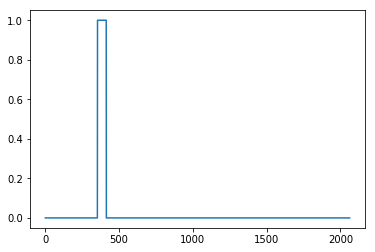

In [85]:
arr1 = insert_ones(np.zeros((1, Ty)), 5000, 6000)
plt.plot(arr1[0])

Finally, we can use `insert_audio_clip` and `insert_ones` to create a new training example.

In [86]:
def create_training_example(regular, trolls):
    """
    Creates a training example with a given a regular clip and a troll.
    
    Arguments:
    regular -- a 30 second regular audio clip
    troll -- a list of audio segments of the "troll"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make regular quieter
    #regular = regular - 20

    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    
    # Select our "troll" audio clip
    # we currently have only one :(
    
    # Insert the audio clip on the regular
    regular, segment_time = insert_audio_clip(regular, trolls[0], previous_segments)
    # Retrieve segment_start and segment_end from segment_time
    segment_start, segment_end = segment_time[0], segment_time[1]
    # Insert labels in "y"
    print(segment_start)
    print(segment_end)
    y = insert_ones(y, segment_start, segment_end)

    # Standardize the volume of the audio clip 
    #regular = match_target_amplitude(regular, -20.0)

    # Export new training example 
    file_handle = regular.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

15893
20882
File (train.wav) was saved in your directory.


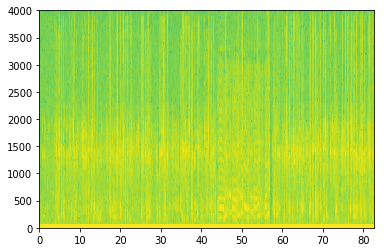

In [87]:
x, y = create_training_example(regulars[100], troll)

Lets listen to the training example we created and compare it to the spectrogram generated above.

In [88]:
IPython.display.Audio("train.wav")

Finally, we can plot the associated labels for the generated training example.

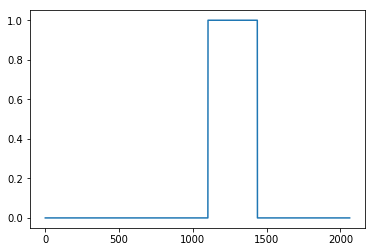

In [89]:
plt.plot(y[0])

## 1.4 - Full training set

We use this process to generate our training set. 

13305
18294
File (train.wav) was saved in your directory.
2475
7464
File (train.wav) was saved in your directory.
3829
8818
File (train.wav) was saved in your directory.
5553
10542
File (train.wav) was saved in your directory.
12561
17550
File (train.wav) was saved in your directory.
1149
6138
File (train.wav) was saved in your directory.
17030
22019
File (train.wav) was saved in your directory.
9551
14540
File (train.wav) was saved in your directory.
10428
15417
File (train.wav) was saved in your directory.
1209
6198
File (train.wav) was saved in your directory.
16014
21003
File (train.wav) was saved in your directory.
7483
12472
File (train.wav) was saved in your directory.
20025
25014
File (train.wav) was saved in your directory.
11716
16705
File (train.wav) was saved in your directory.
10478
15467
File (train.wav) was saved in your directory.
24787
29776
File (train.wav) was saved in your directory.
650
5639
File (train.wav) was saved in your directory.
11352
16341
File (train.wav)

24055
29044
File (train.wav) was saved in your directory.
9058
14047
File (train.wav) was saved in your directory.
18900
23889
File (train.wav) was saved in your directory.
24283
29272
File (train.wav) was saved in your directory.
17859
22848
File (train.wav) was saved in your directory.
20518
25507
File (train.wav) was saved in your directory.
18177
23166
File (train.wav) was saved in your directory.
11558
16547
File (train.wav) was saved in your directory.
11422
16411
File (train.wav) was saved in your directory.
11577
16566
File (train.wav) was saved in your directory.
10343
15332
File (train.wav) was saved in your directory.
1735
6724
File (train.wav) was saved in your directory.
3309
8298
File (train.wav) was saved in your directory.
1696
6685
File (train.wav) was saved in your directory.
21415
26404
File (train.wav) was saved in your directory.
970
5959
File (train.wav) was saved in your directory.
4069
9058
File (train.wav) was saved in your directory.
31
5020
File (train.wav) w

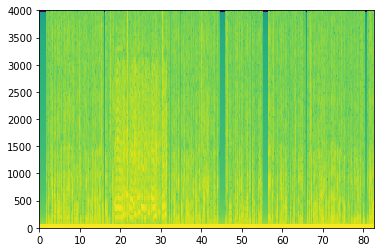

In [90]:
X = []
Y = []

for regular in regulars:
    x, y = create_training_example(regular, troll)
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

## 1.5 - Development set

**TODO:** To test the model, we have a development set of 7 samples of actual trolls the needs to be labeled them by hand, to create a development set using the same distribution as the real inputs. The raw audios are stored in `data/test`, within the downloaded dataset.

For now, I'm using the same synthesized data to test de model (not a good approach, so, if you can, please send your contribution with the labeled dev set)


In [91]:
# Load preprocessed dev set examples
# X_dev = np.load("./XY_dev/X_dev.npy")
# Y_dev = np.load("./XY_dev/Y_dev.npy")

# Temos isso de dimentcao
print(X.shape) 
numero_de_amostras = len(X)

train_size = int(numero_de_amostras * 0.8)

dev_size = numero_de_amostras - train_size

print("Temos {} elementos no total. Vou seperar {} para treino e {} para testes".format(numero_de_amostras, train_size, dev_size))

X_train, X_dev = X[:train_size,:], X[train_size:,:]
Y_train, Y_dev = Y[:train_size,:], Y[train_size:,:]

print(X_train.shape)
print(Y_train.shape)

print(X_dev.shape)
print(Y_dev.shape)


(240, 101, 8267)
Temos 240 elementos no total. Vou seperar 192 para treino e 48 para testes
(192, 101, 8267)
(192, 1, 2064)
(48, 101, 8267)
(48, 1, 2064)


## Model

Now that we've built a dataset, lets write and train a troll detection model! 

The model will use 1-D convolutional layers, GRU layers, and dense layers.

In [92]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
import tensorflow as tf
import keras

In [94]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
        
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                   # ReLu activation
    X = Dropout(0.8)(X)                                         # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    X = BatchNormalization()(X)                       # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    X = BatchNormalization()(X)                       # Batch normalization
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [95]:
model = model(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8267, 101)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2064, 196)         297136    
_________________________________________________________________
batch_normalization_7 (Batch (None, 2064, 196)         784       
_________________________________________________________________
activation_3 (Activation)    (None, 2064, 196)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2064, 196)         0         
_________________________________________________________________
gru_5 (GRU)                  (None, 2064, 128)         124800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 2064, 128)         0         
__________

The output of the network is of shape (None, 2064, 1) while the input is (None, 8267, 101). The Conv1D has reduced the number of steps from 8267 at spectrogram to 2064. 

## Fit the model

I've already trained a model for 50 batches on a GPU.

In [46]:
model = load_model('data/models/50-batches.h5')

OSError: Unable to open file (unable to open file: name = 'data/models/50-batches.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows.

In [97]:
config = tf.ConfigProto(device_count={"CPU": 16})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))


opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
# Tensorboard callback
tbCallback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

In [ ]:
model.fit(X_train.reshape(train_size,8267,101), Y_train.reshape(train_size,2064,1), batch_size = 8, epochs=100, callbacks=[tbCallback])

Epoch 1/100
192/192 [==============================] - 97s 505ms/step - loss: 1.2901 - acc: 0.5031
Epoch 2/100
192/192 [==============================] - 98s 512ms/step - loss: 1.2418 - acc: 0.5061
Epoch 3/100
192/192 [==============================] - 100s 523ms/step - loss: 1.2040 - acc: 0.5093
Epoch 4/100
192/192 [==============================] - 102s 530ms/step - loss: 1.1703 - acc: 0.5130
Epoch 5/100
192/192 [==============================] - 102s 533ms/step - loss: 1.1352 - acc: 0.5164
Epoch 6/100
192/192 [==============================] - 103s 536ms/step - loss: 1.1040 - acc: 0.5183
Epoch 7/100
192/192 [==============================] - 103s 537ms/step - loss: 1.0604 - acc: 0.5229
Epoch 8/100
192/192 [==============================] - 103s 538ms/step - loss: 1.0186 - acc: 0.5305
Epoch 9/100
192/192 [==============================] - 103s 539ms/step - loss: 0.9740 - acc: 0.5378
Epoch 10/100
192/192 [==============================] - 103s 538ms/step - loss: 0.9356 - acc: 0.5456
E

# Salvar o modelo

Vamos Salvar o modelo para acessar depois

In [51]:
model.save('data/models/50-batches.h5')

## Test the model

Finally, let's see how your model performs on the dev set.

In [52]:
loss, acc = model.evaluate(X_dev.reshape(dev_size,8267,101), Y_dev.reshape(dev_size,2064,1))
print("Dev set accuracy = ", acc)

48/48 [==============================] - 3s 57ms/step
Dev set accuracy =  0.833686629931132


This looks pretty good! However, accuracy isn't a great metric for this task, since the labels are heavily skewed to 0's, so a neural network that just outputs 0's would get slightly over 90% accuracy. We could define more useful metrics such as F1 score or Precision/Recall.

For now lets just see how the model does.

# Making Predictions

Now that we have built a working model for troll detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

In [53]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

## Test on dev examples

Now, let's run the model on the last synthesized sample we kept at `train.wav` and see how it goes

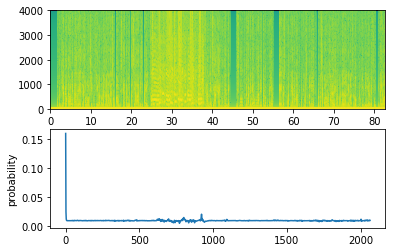

In [54]:
filename = "./train.wav"
prediction = detect_triggerword(filename)

We can see that the model identifies the troll, but that is where it was trained on. Lets see how it goes on a non-troll sample

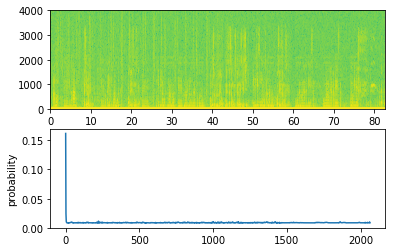

In [55]:
filename  = "./data/train/regular/4.wav"
prediction = detect_triggerword(filename)

Again, not too bad, it stays bellow 60% all the time.

However, we would have to run it against a real-world sample, from those we have collected. I did not manage to convert the real-world samples to the same dimensions of the model input.

**TODO:** convert the real-world samples to the expected spectrogram dimensions in the model input